In [ ]:
#Manufacturing Defects**
#Data  Quality Control**

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
# Load the defect data

In [3]:
df = pd.read_csv('defects_data.csv')

In [5]:
# Check for Nan values
df.isna().sum()


defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
dtype: int64

In [ ]:
#There are no NaN values in this dataset.

In [6]:
# Check for duplicates
df.duplicated().any()

False

In [19]:
#There are no duplicates in this dataset.

In [7]:
df.describe()

,defect_id,product_id,repair_cost
count,1000.000000,1000.000000,1000.000000
mean,500.500000,50.837000,507.627150
std,288.819436,29.480935,289.623615
min,1.000000,1.000000,10.220000
25%,250.750000,26.000000,270.902500
50%,500.500000,51.000000,506.430000
75%,750.250000,77.000000,759.065000
max,1000.000000,100.000000,999.640000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB


In [9]:
# Assign appropriate data type
df['defect_id'] = df['defect_id'].astype('category')
df['product_id'] = df['product_id'].astype('str')
df['defect_date'] = pd.to_datetime(df['defect_date'] )#coerse='error'

df.dtypes

defect_id                  category
product_id                   object
defect_type                  object
defect_date          datetime64[ns]
defect_location              object
severity                     object
inspection_method            object
repair_cost                 float64
dtype: object

📊**A.Classification of various distribution in data**

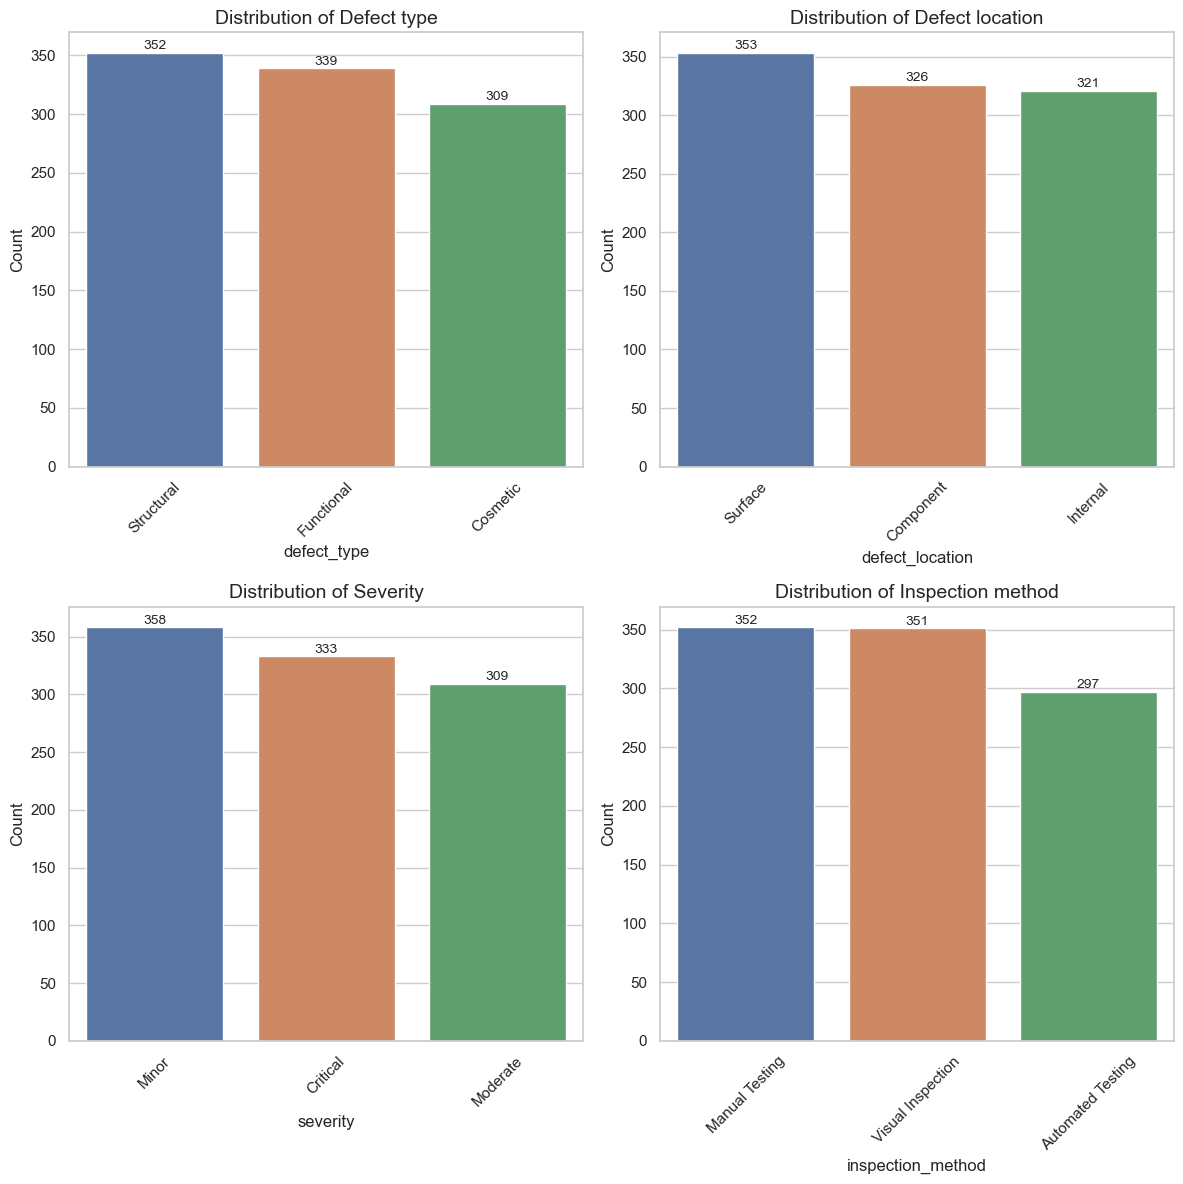

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()  # <-- flatten 2x2 to a list of 4 axes

for idx, col in enumerate(['defect_type', 'defect_location', 'severity', 'inspection_method']):
    data = df[col].value_counts()
    ax = axs[idx]
    
    sns.barplot(x=data.index, y=data.values, hue=data.index, ax=ax )
    
    ax.set_title(f"Distribution of {col.replace('_', ' ').capitalize()}", fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

    # Add value labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.text(p.get_x() + p.get_width() / 2,
                    height + 0.5,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


💰**B. Repair Cost Analysis**

Overall defect cost analysis
by month, by week

In [45]:
def plot_defect_and_cost_trend(df, time_col, title_prefix="Monthly"):
    # Aggregate totals
    repair_cost = df.groupby(time_col)['repair_cost'].sum()
    defect_count = df.groupby(time_col).size()

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Bar plot: number of defects
    bars = ax1.bar(defect_count.index.astype(str), defect_count.values, color='skyblue', label='Number of Defects')
    ax1.set_xlabel(title_prefix)
    ax1.set_ylabel("Number of Defects", color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xticks(range(len(defect_count.index)))
    ax1.set_xticklabels(defect_count.index.astype(str), rotation=45)
    ax1.set_title(f"{title_prefix} Defect Count (Bar) and Repair Cost (Line)")

    # Line plot: repair cost
    ax2 = ax1.twinx()
    line = ax2.plot(repair_cost.index.astype(str), repair_cost.values, color='red', marker='o', linewidth=2, label='Repair Cost')
    ax2.set_ylabel("Repair Cost", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add grid and legend
    ax1.grid(True, linestyle='--', alpha=0.5)
    lines_labels = [bars, line[0]]
    labels = [l.get_label() for l in lines_labels]
    ax1.legend(lines_labels, labels, loc='upper right')

    plt.tight_layout()
    plt.show()

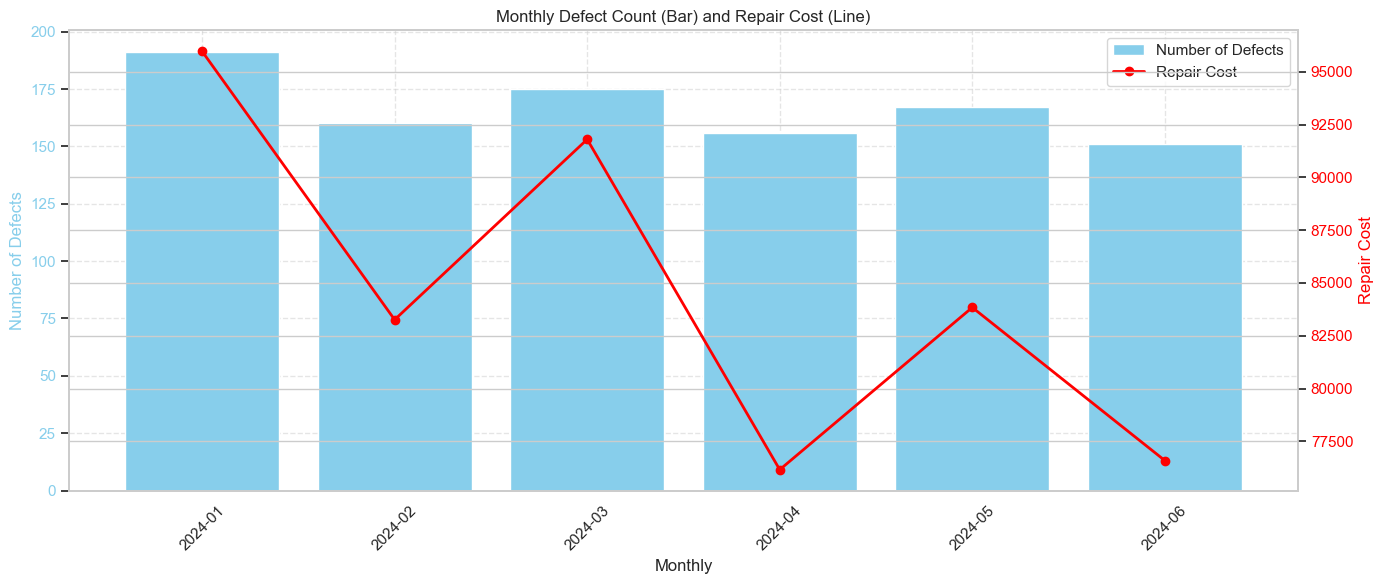

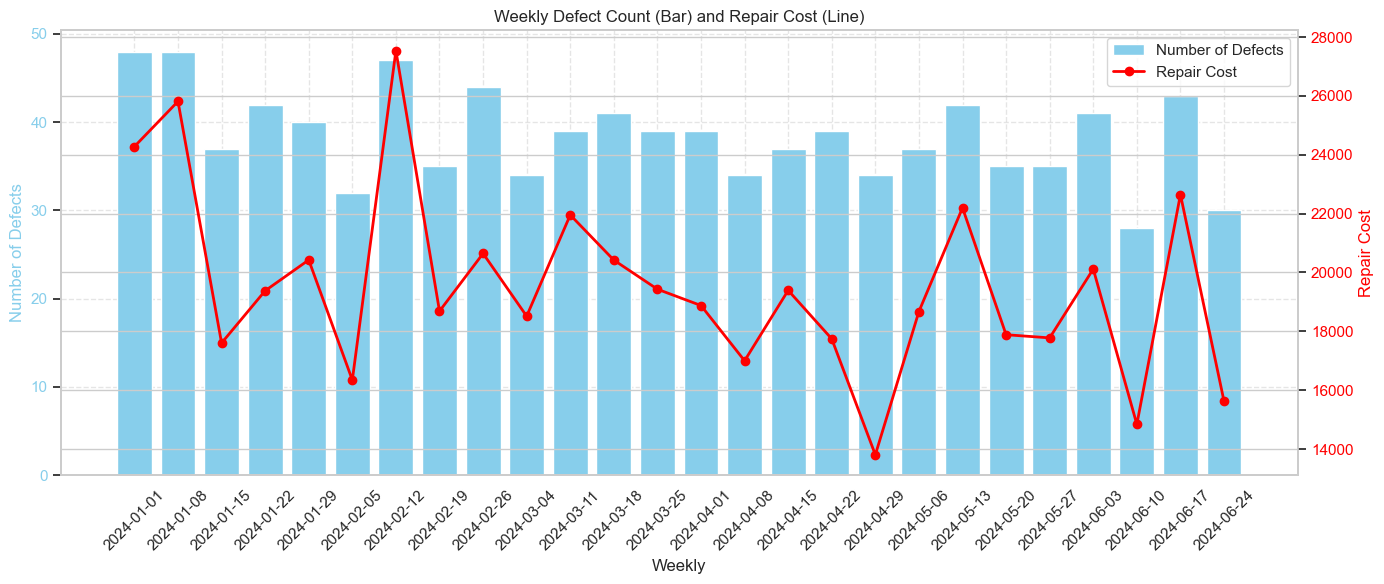

In [46]:
# For monthly trend
plot_defect_and_cost_trend(df, time_col='defect_month', title_prefix='Monthly')

# For weekly trend
plot_defect_and_cost_trend(df, time_col='defect_week', title_prefix='Weekly')


🧩**C. Defect by category**

'defect_type', 'defect_location', 'severity', 'inspection_method'

In [47]:
def plot_category_defect_and_cost_trend(df, time_col, category_col, title_prefix="Monthly", max_categories=10):
    """
    Plots dual-axis chart:
    - Stacked bar chart: defect count by category over time (lighter color)
    - Line plots: total repair cost and per-category repair costs (darker version of same color)
    """
    # Count and cost per category over time
    count_by_category = df.groupby([time_col, category_col]).size().unstack(fill_value=0)
    cost_by_category = df.groupby([time_col, category_col])['repair_cost'].sum().unstack(fill_value=0)
    total_cost = df.groupby(time_col)['repair_cost'].sum()

    # Restrict to top N categories if needed
    top_categories = count_by_category.sum().nlargest(max_categories).index
    count_by_category = count_by_category[top_categories]
    cost_by_category = cost_by_category[top_categories]

    # Define color palette (darker + alpha for bar)
    base_colors = sns.color_palette('tab10', n_colors=len(top_categories))
    color_map = {cat: base_colors[i] for i, cat in enumerate(top_categories)}

    # Plotting
    fig, ax1 = plt.subplots(figsize=(16, 7))

    # Bar chart: stacked by category with lighter alpha
    for cat in top_categories:
        ax1.bar(count_by_category.index.astype(str),
                count_by_category[cat],
                bottom=count_by_category[top_categories].loc[:, top_categories[:top_categories.get_loc(cat)]].sum(axis=1) if top_categories.get_loc(cat) > 0 else None,
                color=color_map[cat],
                alpha=0.4,
                label=cat)

    ax1.set_ylabel("Number of Defects")
    ax1.set_xlabel(title_prefix)
    ax1.set_title(f"{title_prefix} Defects by {category_col} (Bar) and Repair Cost (Line)")
    ax1.set_xticks(range(len(count_by_category.index)))
    ax1.set_xticklabels(count_by_category.index.astype(str), rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # Line chart: one line per category
    ax2 = ax1.twinx()
    ax2.plot(total_cost.index.astype(str), total_cost.values,
             color='black', marker='o', linewidth=2, label='Total Cost')

    for cat in top_categories:
        ax2.plot(cost_by_category.index.astype(str),
                 cost_by_category[cat],
                 color=color_map[cat],
                 linestyle='--',
                 marker='x',
                 linewidth=1.5,
                 label=f"Cost - {cat}")

    ax2.set_ylabel("Repair Cost")
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title="Repair Cost", frameon=False)

    plt.tight_layout()
    plt.show()

🏭1. Defect by category - Monthly🗓️

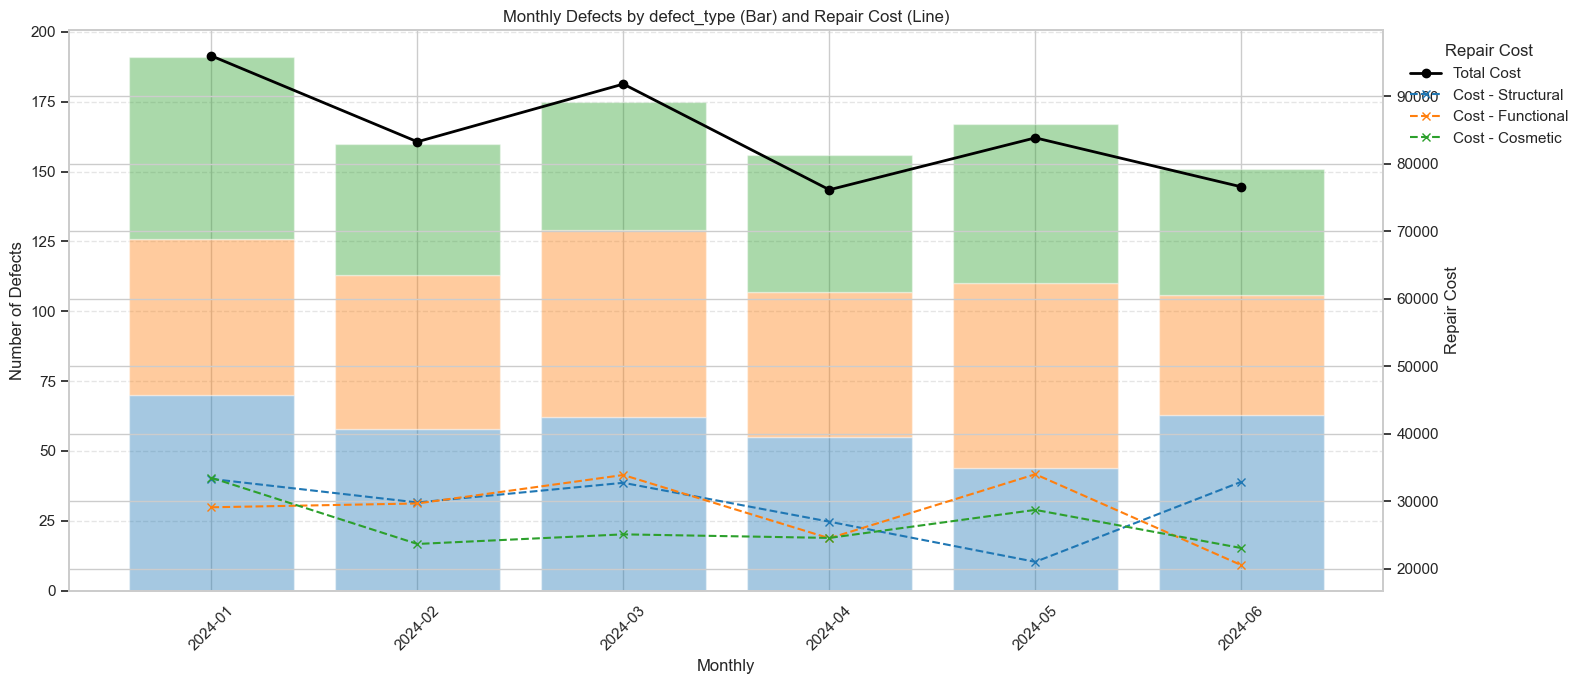

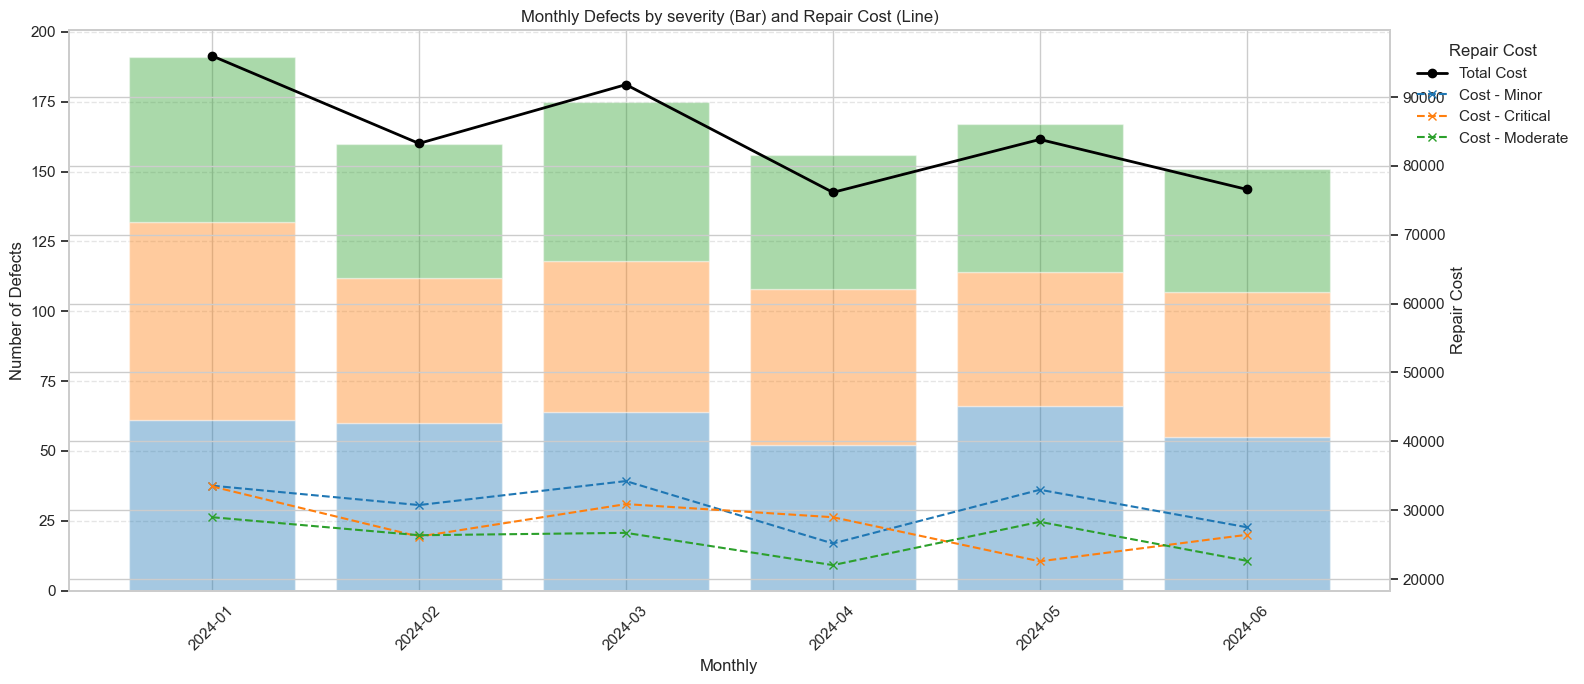

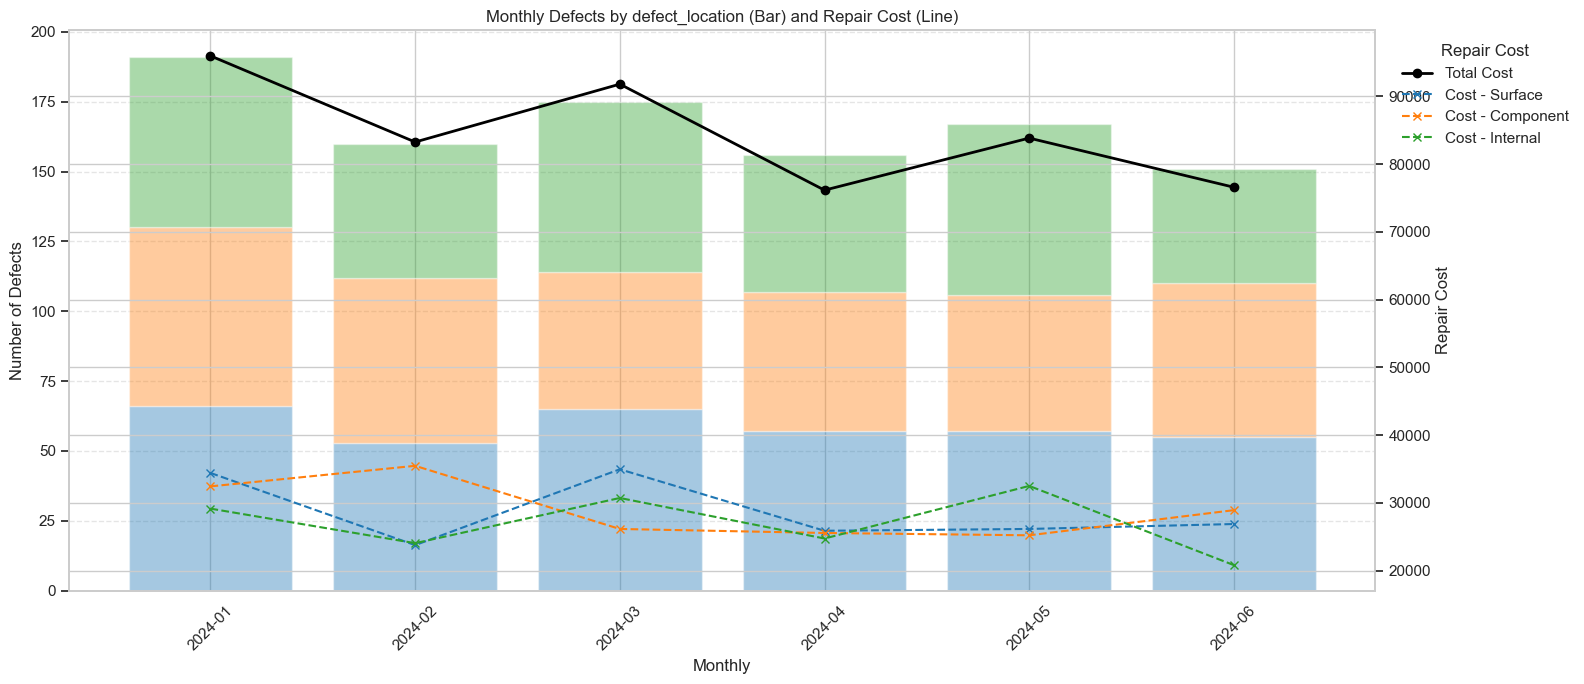

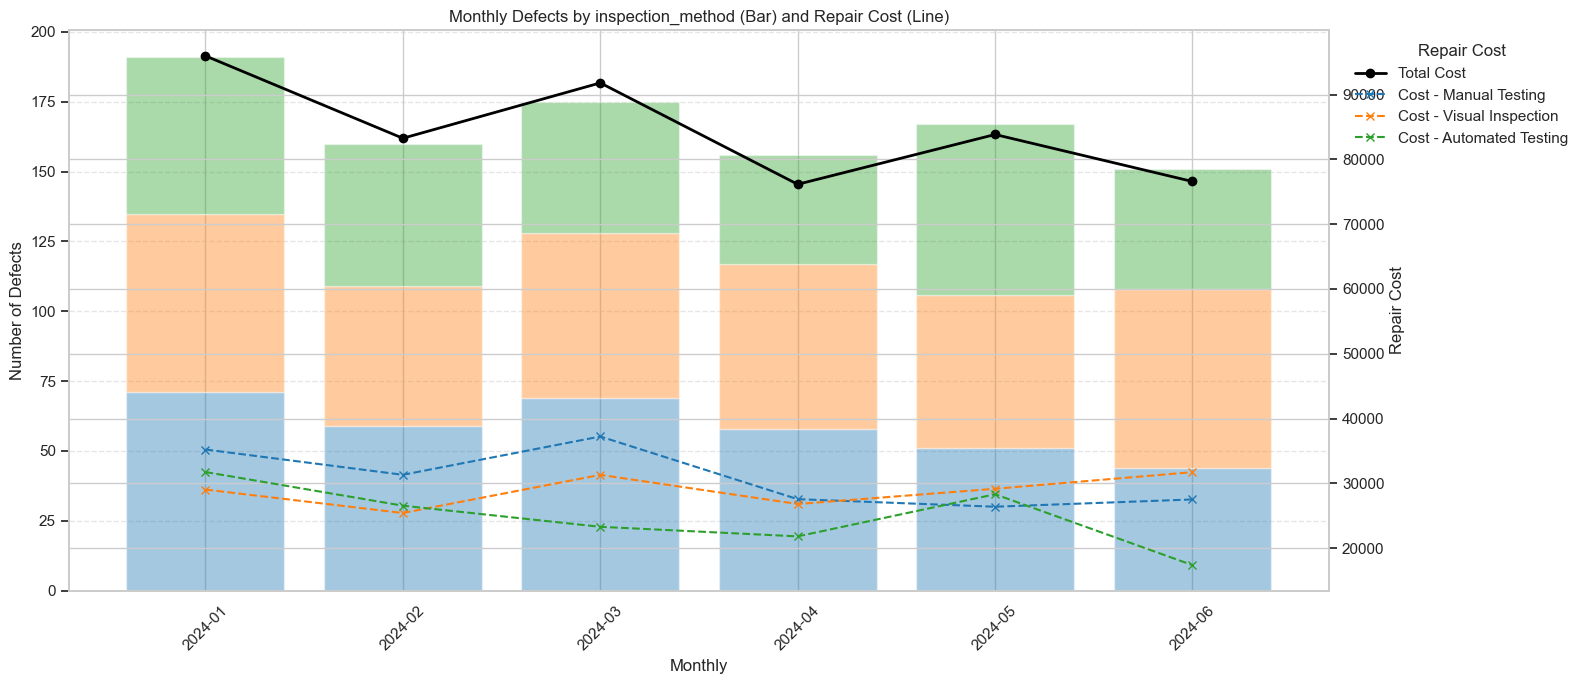

In [37]:
# Plot by defect type
plot_category_defect_and_cost_trend(df, time_col='defect_month', category_col='defect_type', title_prefix='Monthly')

# Plot by severity
plot_category_defect_and_cost_trend(df, time_col='defect_month', category_col='severity', title_prefix='Monthly')

# Plot by defect_location
plot_category_defect_and_cost_trend(df, time_col='defect_month', category_col='defect_location', title_prefix='Monthly')

# Plot by inspection_method
plot_category_defect_and_cost_trend(df, time_col='defect_month', category_col='inspection_method', title_prefix='Monthly')

🏭2. Defect by category - Weekly🗓️

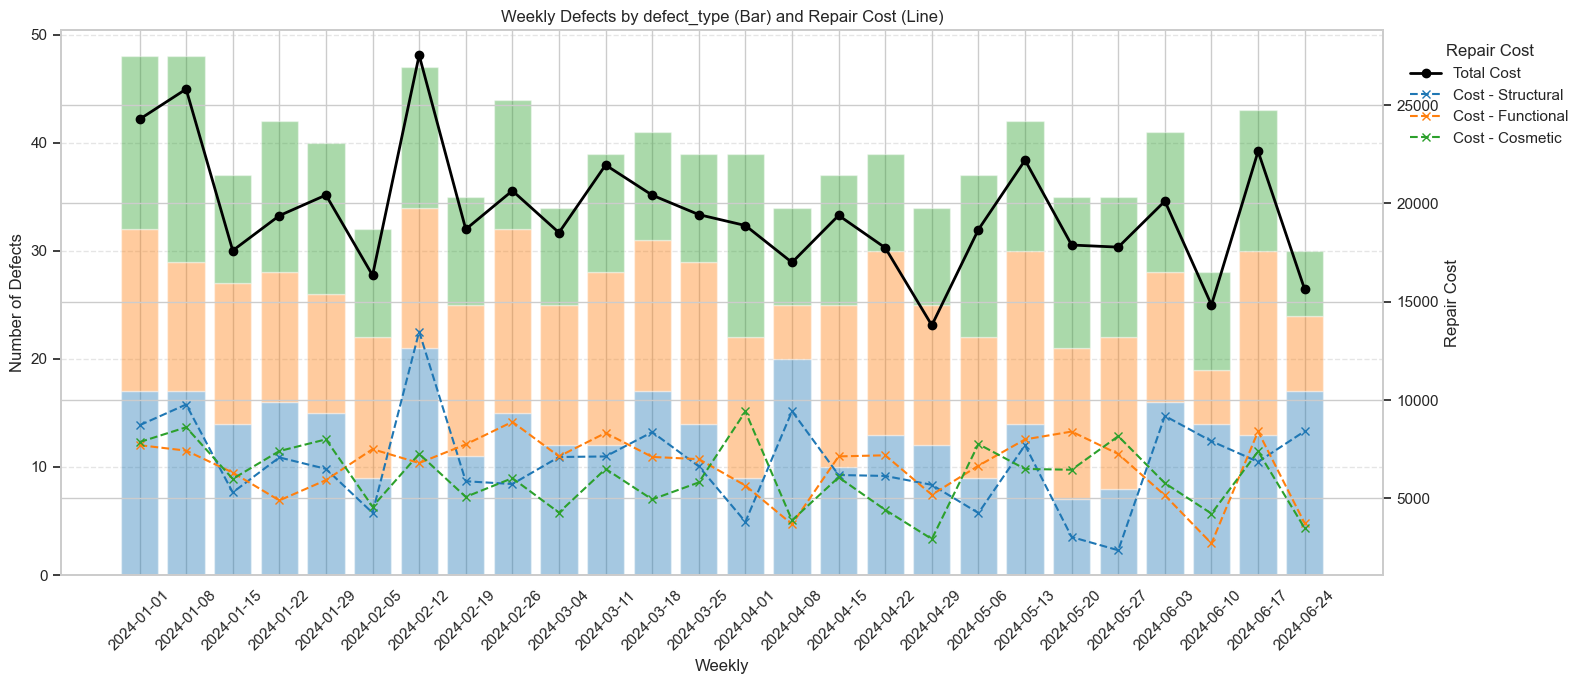

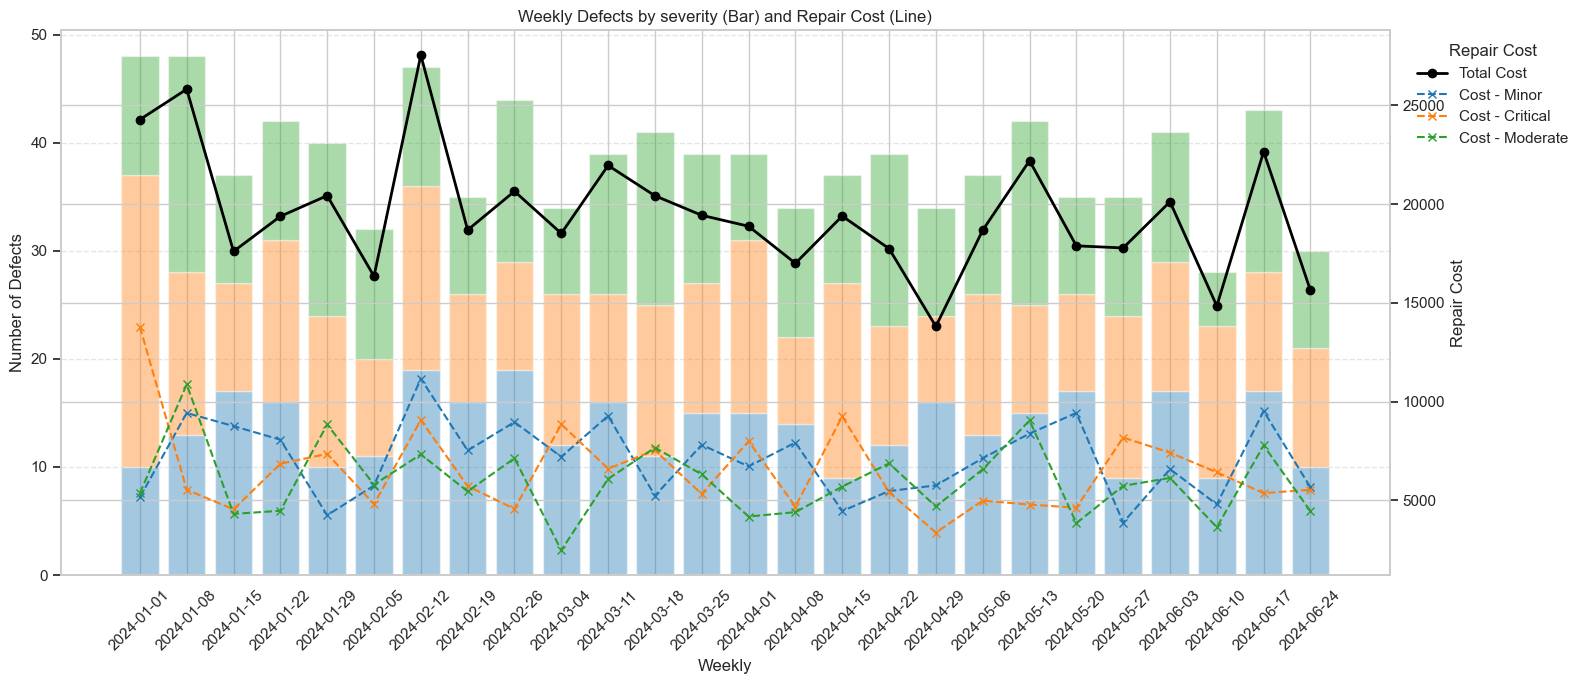

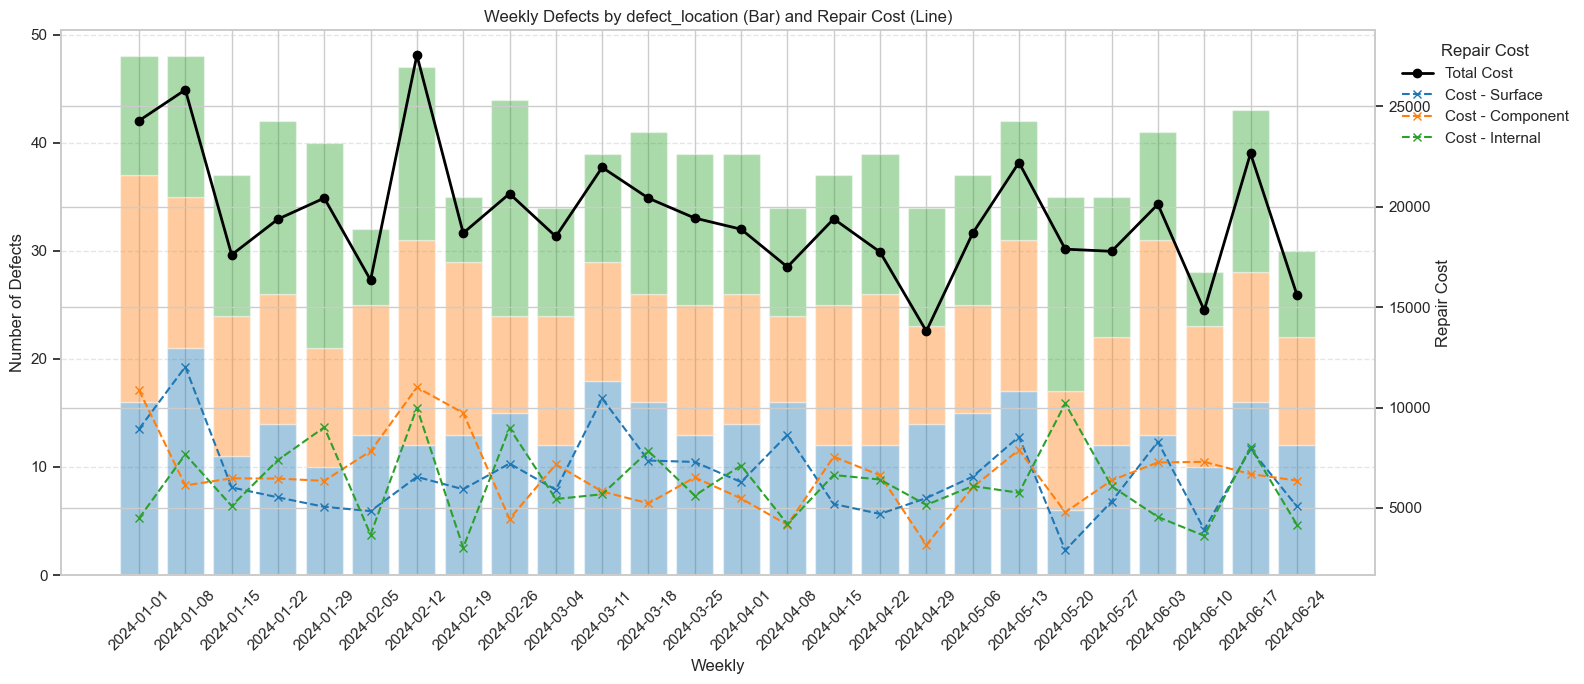

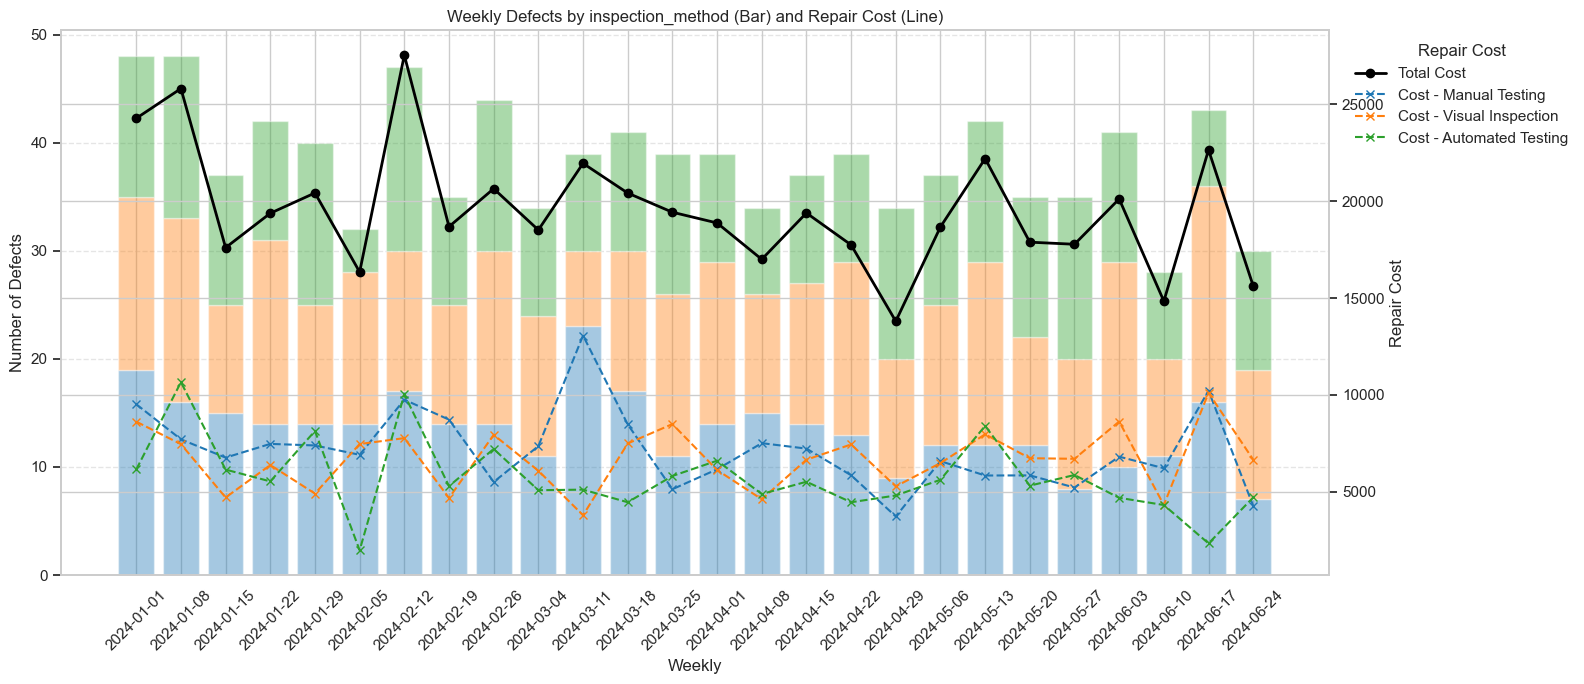

In [43]:
# Plot by defect type
plot_category_defect_and_cost_trend(df, time_col='defect_week', category_col='defect_type', title_prefix='Weekly')

# Plot by severity
plot_category_defect_and_cost_trend(df, time_col='defect_week', category_col='severity', title_prefix='Weekly')

# Plot by defect location
plot_category_defect_and_cost_trend(df, time_col='defect_week', category_col='defect_location', title_prefix='Weekly')

# Plot by inspection method
plot_category_defect_and_cost_trend(df, time_col='defect_week', category_col='inspection_method', title_prefix='Weekly')

💰 **D. Repair Cost by Product**

Cost of repair of top 10 defective products

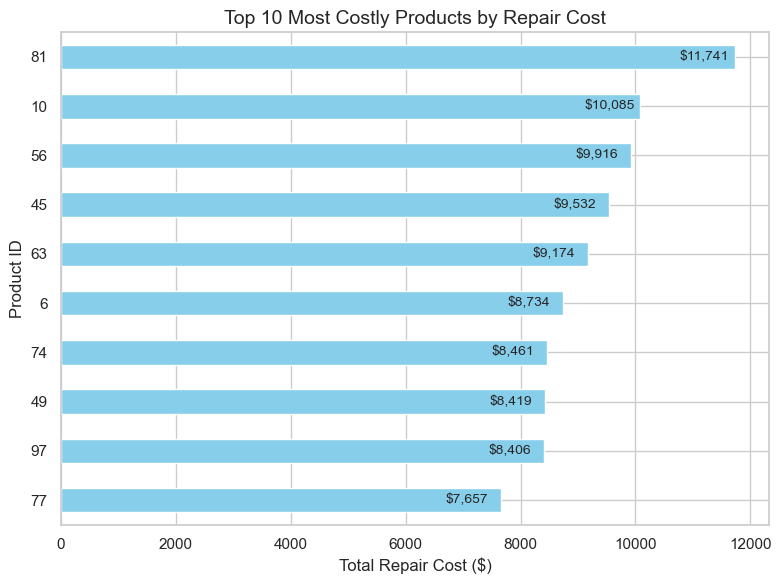

In [33]:
# Top ten most cost products
# Compute total repair cost per product
cost_by_product = df.groupby('product_id', observed=True)['repair_cost'].sum().reset_index()

# Identify the most costly product
most_costly_product = cost_by_product.sort_values(by='repair_cost', ascending=False).head(10).set_index('product_id')

fig, ax = plt.subplots(figsize=(8, 6))
most_costly_product.plot(kind='barh', ax=ax, legend=False, color='skyblue')

# Invert y-axis to show highest cost product at the top
ax.invert_yaxis()

for bar in ax.patches:
    width = bar.get_width()
    ax.annotate(f"${width:,.0f}",
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-40, 0),  # Offset to the right
                textcoords="offset points",
                ha='left', va='center', fontsize=10)

ax.set_title("Top 10 Most Costly Products by Repair Cost", fontsize=14)
ax.set_xlabel("Total Repair Cost ($)")
ax.set_ylabel("Product ID")

plt.tight_layout()
plt.show()

🏷️**E.Top 5 most costly products**

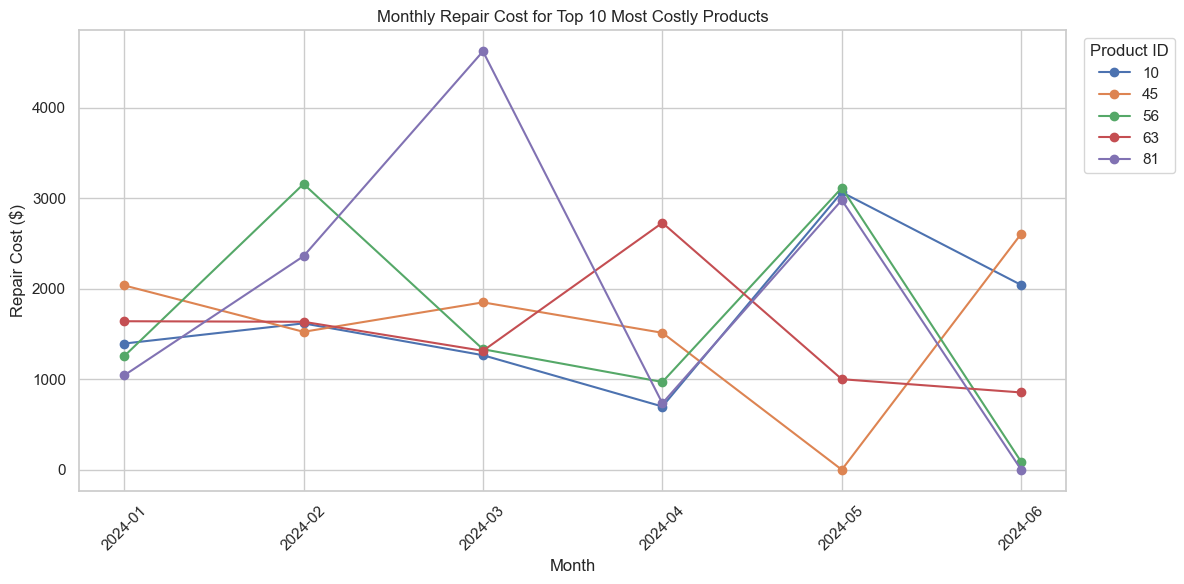

In [32]:

top_5_products = df.groupby('product_id')['repair_cost'].sum() \
                    .sort_values(ascending=False).head(5).index

# Filter for top 5 products
df_top = df[df['product_id'].isin(top_5_products)]

# Compute monthly repair cost per product
monthly_cost_by_product = df_top.groupby(['defect_month', 'product_id'])['repair_cost'].sum().unstack(fill_value=0)

# Plot using line + scatter
plt.figure(figsize=(12, 6))
for product in monthly_cost_by_product.columns:
    plt.plot(monthly_cost_by_product.index, monthly_cost_by_product[product], marker='o', label=product)

plt.title("Monthly Repair Cost for Top 10 Most Costly Products")
plt.xlabel("Month")
plt.ylabel("Repair Cost ($)")
plt.xticks(rotation=45)
plt.legend(title="Product ID", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()